In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gdrive_path = '/content/drive/MyDrive/thesis'

In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt

In [5]:
whole_data = pd.read_csv("Supervised_whole_data.csv")
train_data = pd.read_csv("supervised_train_data.csv")
test_data = pd.read_csv("supervised_test_data.csv")

In [6]:
train_data['Abnormal'] = train_data['Abnormal'].map({0.0: 0, 1.0: 1})
test_data['Abnormal'] = test_data['Abnormal'].map({0.0: 0, 1.0: 1})

In [7]:
train_data.head()

,conclusion,Abnormal
0,EEG is normal.\n(21/11/2006),0
1,EEG is habitual.\n(21/11/2006),0
2,"1) Diffuse delta wave, higher amplitude in the...",1
3,The EEG showed generalised attenuation with as...,1
4,This EEG was within normal limits. No focal or...,0


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
# TEXT CLEANING
TEXT_CLEANING = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

def preprocess(text, stem=False):

    text = re.sub(TEXT_CLEANING, ' ', str(text).lower()).strip()
    tokens = []

    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)

    return " ".join(tokens)

In [11]:
whole_data.conclusion = whole_data.conclusion.apply(lambda x: preprocess(x))
train_data.conclusion = train_data.conclusion.apply(lambda x: preprocess(x))
test_data.conclusion = test_data.conclusion.apply(lambda x: preprocess(x))

In [12]:
class CustomDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [13]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [28]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    predictions = []
    actual_labels = []
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)

    return running_loss / len(data_loader), accuracy

In [15]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    running_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    accuracy = accuracy_score(actual_labels, predictions)
    return running_loss / len(data_loader), accuracy, classification_report(actual_labels, predictions)

In [16]:
def predict_classification(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "abnormal" if preds.item() == 1 else "normal"

In [39]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 300
batch_size = 16
num_epochs = 20
learning_rate = 5e-7

In [30]:
X_train, y_train = train_data["conclusion"].values, train_data["Abnormal"].values
X_test, y_test = test_data["conclusion"].values, test_data["Abnormal"].values

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [49]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = CustomDataset(X_train, y_train, tokenizer, max_length)
val_dataset = CustomDataset(X_valid, y_valid, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [51]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 3
trigger_times = 0
best_model_state_dict = None
best_val_report = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train(model, train_dataloader, optimizer, scheduler, device)
    val_loss, val_accuracy, val_report = evaluate(model, val_dataloader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_report = val_report
        best_model_state_dict = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break


Epoch 1/20
Training Loss: 0.5420
Training Accuracy: 0.7726
Validation Loss: 0.3210
Validation Accuracy: 0.9210

Epoch 2/20
Training Loss: 0.2499
Training Accuracy: 0.9374
Validation Loss: 0.1729
Validation Accuracy: 0.9479

Epoch 3/20
Training Loss: 0.1713
Training Accuracy: 0.9517
Validation Loss: 0.1355
Validation Accuracy: 0.9555

Epoch 4/20
Training Loss: 0.1383
Training Accuracy: 0.9620
Validation Loss: 0.1145
Validation Accuracy: 0.9622

Epoch 5/20
Training Loss: 0.1179
Training Accuracy: 0.9666
Validation Loss: 0.1114
Validation Accuracy: 0.9613

Epoch 6/20
Training Loss: 0.1077
Training Accuracy: 0.9662
Validation Loss: 0.0965
Validation Accuracy: 0.9655

Epoch 7/20
Training Loss: 0.0991
Training Accuracy: 0.9706
Validation Loss: 0.0915
Validation Accuracy: 0.9706

Epoch 8/20
Training Loss: 0.0927
Training Accuracy: 0.9702
Validation Loss: 0.0892
Validation Accuracy: 0.9714

Epoch 9/20
Training Loss: 0.0872
Training Accuracy: 0.9723
Validation Loss: 0.0899
Validation Accuracy:

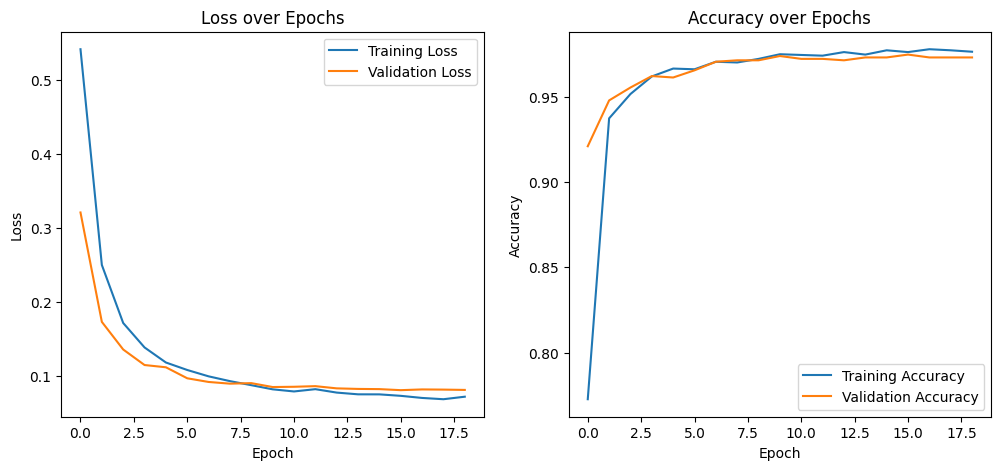

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [71]:
torch.save(best_model_state_dict, 'best_bert_model.pth')

In [72]:
model = BERTClassifier(bert_model_name, num_classes).to(device)
model.load_state_dict(torch.load('best_bert_model.pth'))

<All keys matched successfully>

In [62]:
def test(model, data_loader, device):
    model.eval()
    running_loss = 0.0
    predictions = []
    actual_labels = []
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct_preds / total_samples

    return epoch_loss, epoch_accuracy, classification_report(actual_labels, predictions), predictions, actual_labels

In [55]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()

In [58]:
test_dataset = CustomDataset(X_test, y_test, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [73]:
test_loss, test_accuracy, test_report, test_predictions, test_actual_labels = test(model, test_dataloader, device)

In [74]:
print("Accuracy on Test Dataset:", test_accuracy)
print("Loss on Test Dataset:", test_loss)

Accuracy on Test Dataset: 0.97
Loss on Test Dataset: 0.07303768250858411


In [75]:
print(test_report)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       176
           1       0.97      0.98      0.98       324

    accuracy                           0.97       500
   macro avg       0.97      0.96      0.97       500
weighted avg       0.97      0.97      0.97       500



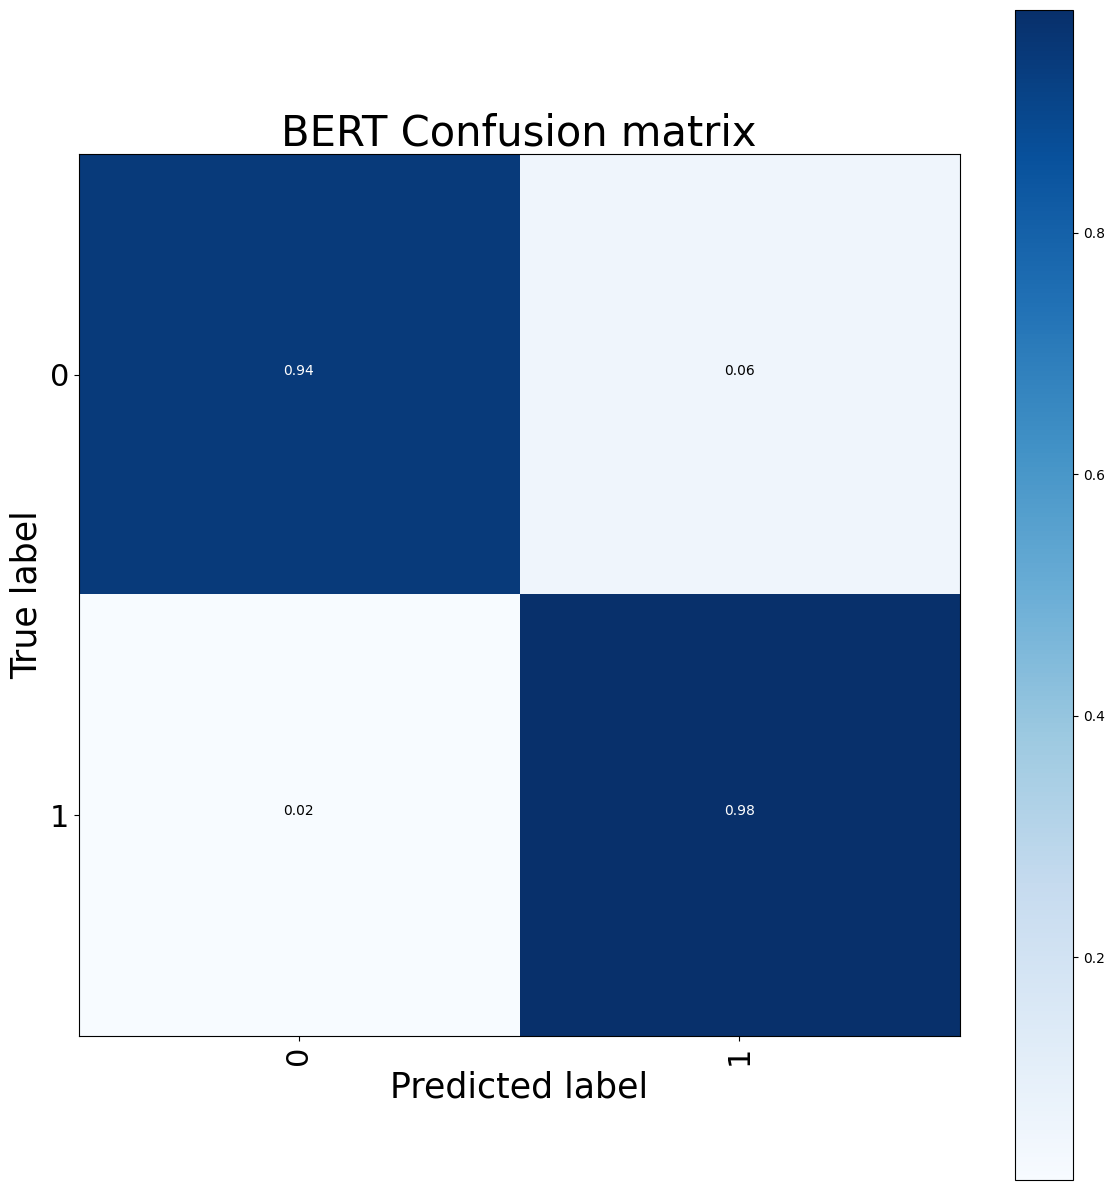

In [76]:
# Plot confusion matrix
import numpy as np
cnf_matrix = confusion_matrix(test_actual_labels, test_predictions)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(test_actual_labels), title="BERT Confusion matrix")
plt.show()